In [15]:
import os

import sys
sys.path.append("../")

import pandas as pd
import numpy as np
from scipy.stats import uniform
import warnings
from joblib import dump
import json

from sklearnex import patch_sklearn # For intel optimization
patch_sklearn() # For intel optimization

from feature_engine.selection import DropConstantFeatures, DropCorrelatedFeatures

from B_resources.b_Python_sklearn.custom_modeling_functions import train_and_time, custom_specificity_multiclass
from C_scrub.b_Python_Pandas_data_engineering import scrub_feature_engineering

from imblearn.pipeline import Pipeline as Pipeline_imblearn
from imblearn.under_sampling import NearMiss

from sklearn.pipeline import Pipeline as Pipeline_sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, precision_score, recall_score, f1_score, matthews_corrcoef, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.exceptions import UndefinedMetricWarning
from scipy.stats import randint


from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# System setup

In [31]:
BASE_DIR = os.path.dirname(os.getcwd())
DATA_DIR = os.path.join(BASE_DIR, 'A_data')
RESOURCES_DIR = os.path.join(BASE_DIR, 'B_resources', 'b_Python_sklearn')

# Startup procedures

## Get data and metadata

In [17]:
data_compet = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
data_compet.drop(['id'], axis=1, inplace=True)
data_orig = pd.read_csv(os.path.join(DATA_DIR, "horse.csv"))

data = pd.concat([data_compet, data_orig], ignore_index=True)

data.dropna(subset=['outcome'], inplace=True)
data.drop_duplicates(inplace=True)
data.reset_index(drop=True, inplace=True)
del data_compet, data_orig

## prepare data

In [18]:
data = scrub_feature_engineering(data, train=True)

## Parameters definition

In [19]:
random_seed = 4000

# test split size
split_size = 0.8

#Number of cross-validation folds
n_splits = 4

# Random states
cv_random_state=random_seed
hyperparam_random_state=random_seed
np.random.seed(random_seed)

# # Max iterations, when applied
logisticReg_max_iter = 10000
linearSVM_max_iter = 1000000

# number of iteration for RamdomizedSearchCV
logistReg_grid_n_iter_search = 2*20
linearSVM_grid_n_iter_search = 2*20
RF_grid_n_iter_search = 4*20
XGB_grid_n_iter_search = 6*20
NB_grid_n_iter_search = 20

## Hyperparameters grids

In [20]:
logistic_params_dist = {
    'classifier__C': uniform(loc=0.01, scale=100),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['saga']
}

linear_svm_params_dist = {
    'classifier__C': uniform(loc=0.01, scale=100),
    'classifier__tol': uniform(loc=1e-6, scale=1e-3),
    'classifier__class_weight': [None], 
}

random_forest_params_dist = {
    'classifier__n_estimators': randint(10, 315),
    'classifier__max_depth': randint(1, 20),
    'classifier__min_samples_split': randint(2, 50),
    'classifier__min_samples_leaf': randint(1, 50),
    'classifier__bootstrap': [True],
    'classifier__criterion': ['gini']
}

xgboost_params_dist = {
    'classifier__learning_rate': uniform(0.01, 0.19),
    'classifier__n_estimators': [80],
    'classifier__max_depth': randint(3, 10),
    'classifier__min_child_weight': randint(1, 10),
    'classifier__gamma': uniform(0, 0.5),
    'classifier__subsample': uniform(0.6, 0.4),
    'classifier__colsample_bytree': uniform(0.6, 0.4),
}

naive_bayes_params_dist = {
    'classifier__var_smoothing': uniform(1e-10, 1e-8)
}

## Split data

In [21]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('outcome', axis=1), 
                                                    data['outcome'], test_size=split_size, stratify=data['outcome'])

stratified_kfold = StratifiedKFold(n_splits=n_splits, random_state=cv_random_state, shuffle=True)

## Feature preprocessing definition

## Define metrics functions

In [22]:
scorers = {
    'precision': make_scorer(precision_score, average='macro'),
    # 'roc_auc': make_scorer(roc_auc_score, multi_class='ovr', average='macro', needs_proba=True), # removed because it makes too slow tuning of one the models
    'sensitivity': make_scorer(recall_score, average='macro'),
    'specificity': make_scorer(custom_specificity_multiclass),
    'bal_accuracy': make_scorer(balanced_accuracy_score),
    'f_meas': make_scorer(f1_score, average='macro'),
    'mcc': make_scorer(matthews_corrcoef)
}

# Defining models

## Create model-specific pipelines

In [23]:
logistic_pipeline = Pipeline_imblearn([
    ('sampler', NearMiss()), 
    ('classifier', LogisticRegression(max_iter=logisticReg_max_iter))
])

linear_svm_pipeline = Pipeline_imblearn([
    ('sampler', NearMiss()),
    ('classifier', LinearSVC(max_iter=linearSVM_max_iter, dual='auto'))
])

random_forest_pipeline = Pipeline_imblearn([
    ('sampler', NearMiss()), # Cannot deal with imbalanced dataset (UndefinedMetricWarning that cannot be suppressed)
    ('classifier', RandomForestClassifier(random_state=hyperparam_random_state))
])

xgboost_pipeline = Pipeline_imblearn([
    ('sampler', NearMiss()),
    ('classifier', XGBClassifier(random_state=hyperparam_random_state, eval_metric='mlogloss'))
])

naive_bayes_pipeline = Pipeline_imblearn([
    ('sampler', NearMiss()),
    ('classifier', GaussianNB())
])

## Define hyperparameters search grid

In [24]:
logistic_search = RandomizedSearchCV(
    logistic_pipeline, param_distributions=logistic_params_dist, n_iter=logistReg_grid_n_iter_search,
    cv=stratified_kfold, verbose=1, random_state=hyperparam_random_state, n_jobs=-1, scoring=scorers, refit=False,
)

linear_svm_search = RandomizedSearchCV(
    linear_svm_pipeline, param_distributions=linear_svm_params_dist, n_iter=linearSVM_grid_n_iter_search,
    cv=stratified_kfold, verbose=1, random_state=hyperparam_random_state, n_jobs=-1, scoring=scorers, refit=False
)

random_forest_search = RandomizedSearchCV(
    random_forest_pipeline, param_distributions=random_forest_params_dist, n_iter=RF_grid_n_iter_search,
    cv=stratified_kfold, verbose=1, random_state=hyperparam_random_state, n_jobs=-1, scoring=scorers, refit=False
)

xgboost_search = RandomizedSearchCV(
    xgboost_pipeline, param_distributions=xgboost_params_dist, n_iter=XGB_grid_n_iter_search,
    cv=stratified_kfold, verbose=1, random_state=hyperparam_random_state, n_jobs=-1, scoring=scorers, refit=False
)

naive_bayes_search = RandomizedSearchCV(
    naive_bayes_pipeline, param_distributions=naive_bayes_params_dist, n_iter=NB_grid_n_iter_search,
    cv=stratified_kfold, verbose=1, random_state=hyperparam_random_state, n_jobs=-1, scoring=scorers, refit=False
)

## Fit models

In [25]:
results = []
training_times = {}

models = {
    "Logistic Regression": logistic_search,
    "Linear SVM": linear_svm_search,
    "Random Forest": random_forest_search,
    "XGBoost": xgboost_search,
    "Naive Bayes": naive_bayes_search
    # Add other models as needed
}
      
for model_name, model_search in models.items():
    duration = train_and_time(model_search, X_train, y_train)
    training_times[model_name] = duration

    for scorer_name in scorers.keys():
        mean_scores = model_search.cv_results_[f'mean_test_{scorer_name}']
        std_scores = model_search.cv_results_[f'std_test_{scorer_name}']

        for i, (mean, std) in enumerate(zip(mean_scores, std_scores)):
            results.append({
                'Model': model_name,
                'Metric': scorer_name,
                'Mean': mean,
                'Std': std,
                'Params': model_search.cv_results_['params'][i]
            })


for model_name, duration in training_times.items():
    print(f"Training time for {model_name}: {duration:.2f} seconds")

Fitting 4 folds for each of 5 candidates, totalling 20 fits
Training time for XGBoost: 10.84 seconds


# Model evaluation and selection

## Compare models metrics

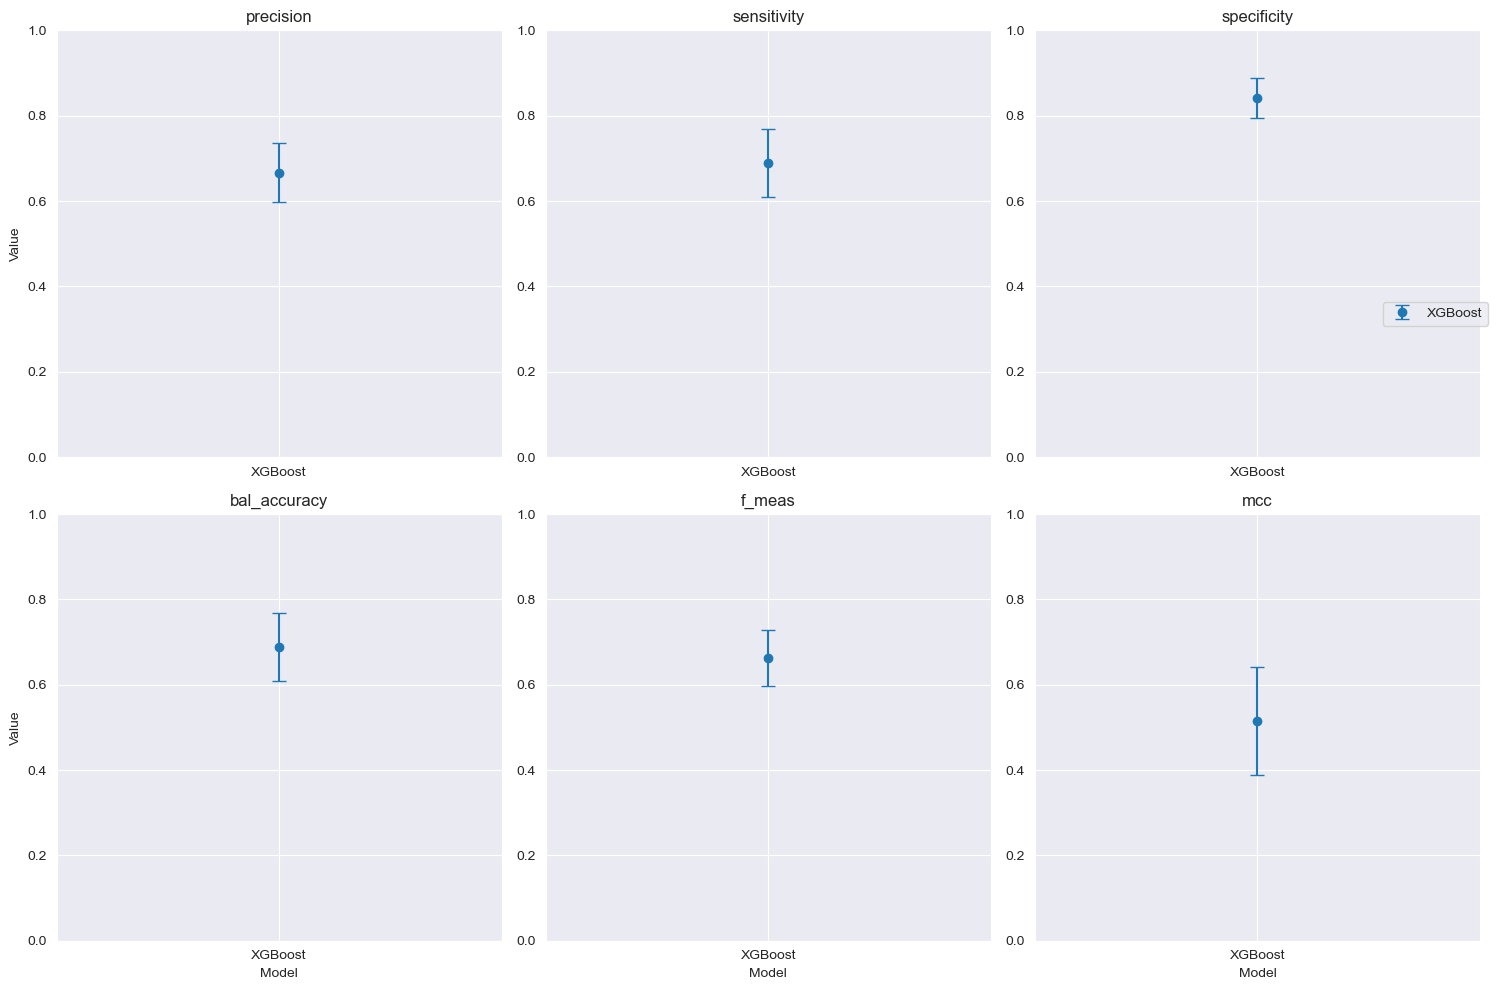

In [26]:
results_df = pd.DataFrame(results)

# Chosen metrics
selected_metric = 'f_meas'

# Sort the DataFrame by selected metric and then by 'Model'
sorted_df = results_df[results_df['Metric'] == selected_metric].sort_values(by=['Mean'], ascending=False)

best_models = []
for model_name in models.keys():
    best_models.append(sorted_df[sorted_df['Model'] == model_name].iloc[0])

# Filter the original results DataFrame to only include these entries
best_params = [model['Params'] for model in best_models]
filtered_df = results_df[results_df['Params'].isin(best_params)]

metrics = filtered_df['Metric'].unique()
n_metrics = len(metrics)
n_models = len(models)
trained_models = filtered_df['Model'].unique()

n_rows = -(-n_metrics // 3)  # Ceiling division to get the number of rows required
fig, axs = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows))

if n_rows == 1:
    axs = [axs]

for idx, metric in enumerate(metrics):
    row, col = divmod(idx, 3)
    ax = axs[row][col]

    metrics_data = filtered_df[filtered_df['Metric'] == metric]
    for i, model in enumerate(trained_models):
        model_data = metrics_data[metrics_data['Model'] == model]
        if not model_data.empty:
            ax.errorbar(i, model_data['Mean'].values[0],
                        yerr=1.96*model_data['Std'].values[0], #95% of confidence, without considering the sample size
                        fmt='o', label=model, capsize=5)
    ax.set_title(metric)
    ax.set_xticks(list(range(n_models)))
    ax.set_xticklabels(trained_models)
    ax.set_ylim(0, 1)

    if col == 0:
        ax.set_ylabel('Value')
    if row == n_rows - 1:
        ax.set_xlabel('Model')

# Remove the last two subplots in the third row, if they exist
if n_rows > 2:
    for col in range(1, 3):
        fig.delaxes(axs[2][col])

# Adjust the legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(1, 0.7))

plt.tight_layout()
plt.show()


## Select best model and retrain with all data

In [27]:
selectedModel = 'XGBoost'
# selectedModel = 'Logistic Regression'
# final_max_iter = logisticReg_max_iter
# 
best_params = filtered_df[filtered_df['Model'] == selectedModel].iloc[0]['Params']

# finalModel_Params = LogisticRegression(
#     C=best_params['classifier__C'],
#     penalty=best_params['classifier__penalty'],
#     solver=best_params['classifier__solver'],
#     max_iter=final_max_iter
# )

finalModel_Params = XGBClassifier(
    learning_rate=best_params['classifier__learning_rate'],
    n_estimators=best_params['classifier__n_estimators'],
    max_depth=best_params['classifier__max_depth'],
    min_child_weight=best_params['classifier__min_child_weight'],
    gamma=best_params['classifier__gamma'],
    subsample=best_params['classifier__subsample'],
    colsample_bytree=best_params['classifier__colsample_bytree'],    
    random_state=hyperparam_random_state,
    eval_metric='mlogloss'
)

# finalModel_Params = RandomForestClassifier(
#     n_estimators=best_params['classifier__n_estimators'],
#     max_depth=best_params['classifier__max_depth'],
#     min_samples_split=best_params['classifier__min_samples_split'],
#     min_samples_leaf=best_params['classifier__min_samples_leaf'],
#     bootstrap=best_params['classifier__bootstrap'],
#     criterion=best_params['classifier__criterion'],
#     random_state=hyperparam_random_state
# ) 

finalPipeline = Pipeline_imblearn([
    ('sampler', NearMiss()),
    ('classifier', finalModel_Params)
])

finalPipeline.fit(X_train, y_train)

finalModel = finalPipeline.named_steps['classifier']

## Get metrics over test data

In [28]:
y_pred = finalModel.predict(X_test)
y_prob = finalModel.predict_proba(X_test)

finalResults = {}

for metric, scorer in scorers.items():
    score = scorer(finalModel, X_test, y_test)
    finalResults[metric] = score

for metric, value in finalResults.items():
    print(f"{metric}: {value:.4f}")

precision: 0.6077
sensitivity: 0.6325
specificity: 0.8127
bal_accuracy: 0.6325
f_meas: 0.6044
mcc: 0.4278


## Plot confusion matrix

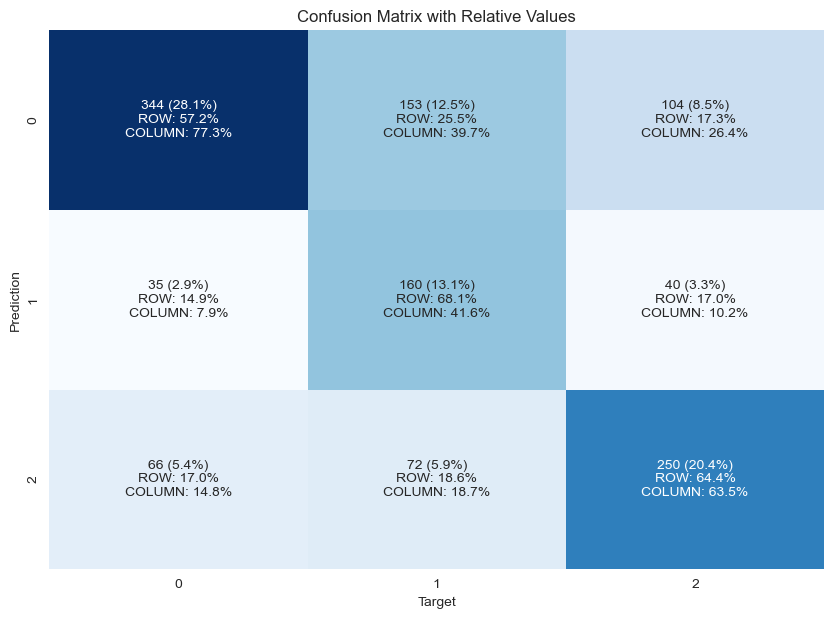

In [29]:
cm = confusion_matrix(y_test, y_pred)

# Calculate the relative percentages
total = np.sum(cm)
percentage_total = (cm / total) * 100
percentage_row = (cm.T / cm.sum(axis=1)).T * 100
percentage_col = (cm / cm.sum(axis=0)) * 100

labels = [
    f"{abs_val} ({p_total:.1f}%)\nROW: {p_row:.1f}%\nCOLUMN: {p_col:.1f}%"
    for abs_val, p_total, p_row, p_col in zip(
        cm.flatten(), percentage_total.flatten(), percentage_row.flatten(), percentage_col.flatten()
    )
]
labels = np.array(labels).reshape(cm.shape)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.title('Confusion Matrix with Relative Values')
plt.show()


## Probability of predicted classes

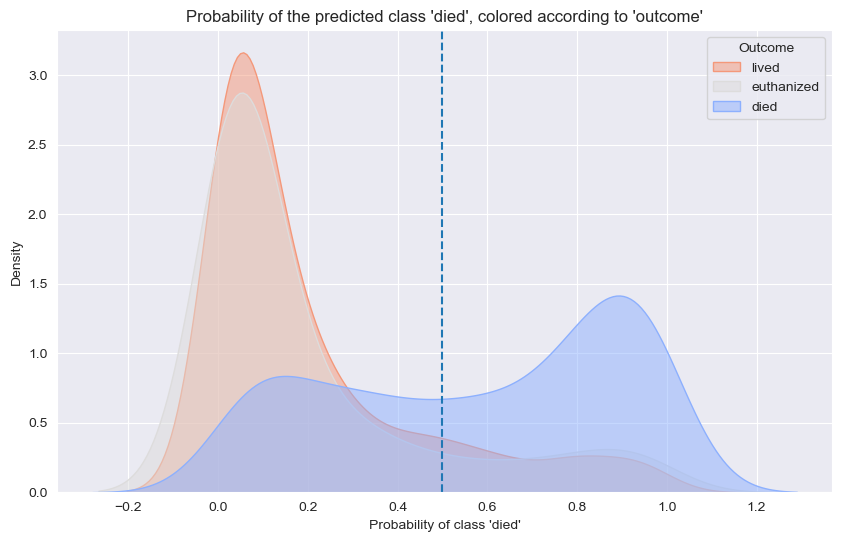

In [30]:
prob_class_preferred = y_prob[:, 2]

plot_data = pd.DataFrame({
    '.prob_class_preferred': prob_class_preferred,
    'outcome': y_test
})

plt.figure(figsize=(10, 6))
sns.kdeplot(data=plot_data, x=".prob_class_preferred", hue="outcome", fill=True, common_norm=False, alpha=0.5, palette="coolwarm")
plt.axvline(x=0.5, linestyle="--")
plt.title("Probability of the predicted class 'died', colored according to 'outcome'")
plt.xlabel("Probability of class 'died'")
plt.legend(title='Outcome', labels=['lived', 'euthanized', 'died'])
plt.show()


## Save model

In [32]:
dump(finalModel, os.path.join(RESOURCES_DIR, 'classifierXGBoost.pkl'))

['/home/jgsolar/Documentos/SHARED/Projetos Pessoais/multiplatform_classifier/B_resources/b_Python_sklearn/classifierXGBoost2.pkl']